In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import seaborn as sns

import trompy as tp

colors_PVH = "#219C90"
colors_VMH  = "#90219c"

colors = [colors_PVH, colors_VMH]

cmap = "RdBu_r"

In [2]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")

with open(DATAFOLDER / "restricted_dark.pickle", 'rb') as handle:
    PVH = pickle.load(handle)

with open(DATAFOLDER / "HL3_restricted_dark.pickle", 'rb') as handle:
    VMH = pickle.load(handle)    

In [3]:
PVH_list_of_mice = []
VMH_list_of_mice = []

mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                    "HL202", "HL205", "HL206", "HL211",
                    "HL301", "HL304", "HL305"]

#"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
#HL 306, 308 have no virus
#HL301, HL304, HL305 have poor fiber placement
#HL313 - HL318 are control mice


for key, val in PVH.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in PVH_list_of_mice:
            PVH_list_of_mice.append(val["mouse_ID"])
        
for key, val in VMH.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in VMH_list_of_mice:
            VMH_list_of_mice.append(val["mouse_ID"])

In [82]:
import numpy as np
def get_snips(data, mice):
    all_snips = []
    all_latencies = []
    max_signals = []
    kwargs = {"bins": 150, "trial_length": 15, "baseline_length": 5}
    pre = 5
    post = 10
    mineventlength = 8
    binlength = 0.1
    for mouse in mice:
        used_rStarts = []
        for key, val in data.items():
            if val["mouse_ID"] == mouse:
                if len(val["licks"]) < 10:
                    continue
                lickdata = tp.lickCalc(val["licks"], minrunlength=3)
                snipper = tp.Snipper(val["corrected"],
                                     lickdata["rStart"],
                                     end=lickdata["rEnd"],
                                     fs=val["fs"],
                                     pre=pre,
                                     post=post,
                                     binlength=binlength,
                                     zscore=True
                                     )
                snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6, 2])
                snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
                
                # Append each snip to the all_snips list
                all_snips.extend(snipper.snips)
                # Calculate max signal between indices 140 and 240 for each snip
                for snip in snipper.snips:
                    max_signal = np.max(snip[140:240])
                    max_signals.append(max_signal)
                # Assuming each snip corresponds to a start, track the used rStart values
                used_rStarts.extend(lickdata["rStart"][:len(snipper.snips)])
        # Sort the used rStart values to ensure correct order
        used_rStarts = sorted(used_rStarts)
        # Calculate latencies only for the used rStart values
        latencies = np.diff(used_rStarts)
        all_latencies.extend(latencies)
    # Ensure the number of snips matches the number of latencies
    if len(all_snips) > len(all_latencies):
        all_snips = all_snips[:len(all_latencies)]
        max_signals = max_signals[:len(all_latencies)]
    # Return a single dictionary with all snips, latencies, and max signals
    return {
        "snips": np.array(all_snips),
        "latency": all_latencies,
        "max_signal": max_signals
    }

In [83]:
test_mouse = ["HL212"]

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

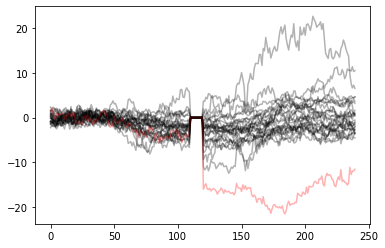

In [84]:
test = get_snips(PVH, test_mouse)

In [85]:
test["snips"]

array([[-0.7831834 , -0.50286634, -0.4608086 , ..., -0.3810431 ,
         0.45840905,  1.01282002],
       [-0.06250661, -0.41807471, -0.29253846, ...,  0.36682013,
         0.57509073,  0.66828086],
       [ 0.95278025, -0.1263989 , -0.10852018, ...,  0.68722383,
         1.05101636,  0.30566444],
       ...,
       [-2.25714473, -1.71452628, -2.03642289, ..., -4.94346828,
        -4.42094534, -4.55437211],
       [-0.99134094, -0.29519917, -0.60975197, ..., -3.44891942,
        -3.13288584, -3.53303427],
       [ 0.33140278,  0.67980497,  1.12494344, ..., -1.26915997,
        -1.28376102, -1.17619905]])

In [86]:
test["latency"]

[40.064286719999984,
 12.322570240000005,
 43.96548095999998,
 63.23863552,
 2.124021760000005,
 8.048967680000032,
 10.417111040000009,
 4.295065599999987,
 12.283084799999983,
 23.16468223999999,
 11.418009600000005,
 4.925358080000024,
 14.337310720000005,
 13.054935039999975,
 26.375290880000023,
 5.913477119999982,
 25.45516544000003,
 102.16505343999995,
 28.736389120000013,
 57.780305920000046,
 20.436418559999993,
 97.92520191999995,
 9.65443584000002,
 118.6103296,
 17.213194240000007]

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 2 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

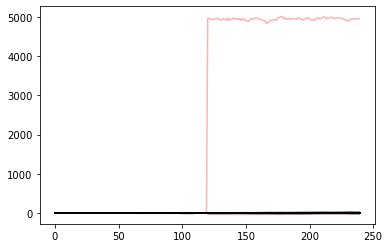

In [87]:
PVH_snips= get_snips(PVH, PVH_list_of_mice)
VMH_snips = get_snips(VMH, VMH_list_of_mice)

In [88]:
PVH_snips

{'snips': array([[-0.37235188, -0.39237369,  0.35959379, ...,  0.21877705,
         -0.29549481, -0.1237642 ],
        [ 0.8149484 , -1.16065262, -0.97132061, ..., -3.98483633,
         -4.10612109, -5.62619761],
        [ 0.68832235,  0.3736057 , -1.52477473, ...,  2.97719163,
          1.13937183,  1.64792841],
        ...,
        [-1.51234533, -0.90466663, -0.88006901, ...,  3.54259542,
          4.19271795,  3.59301327],
        [-0.15236464,  0.03832826,  0.3683411 , ...,  4.53775787,
          4.35871188,  4.63494246],
        [-1.48818747, -1.37692486, -1.05190472, ..., -2.63578822,
         -2.95753291, -2.13265143]]),
 'latency': [30.784552960000013,
  41.47822592,
  15.608709119999986,
  12.951224320000023,
  55.62155007999999,
  36.474388480000016,
  4.9846681600000124,
  29.158932479999976,
  100.74570752,
  3.469312000000002,
  9.768796160000022,
  110.72192512000004,
  36.64592895999999,
  32.26615807999997,
  107.28783871999997,
  795.0073856000001,
  58.17630719999988,

Pearson correlation coefficient: -0.011
P-value: 0.868
The correlation is not statistically significant.


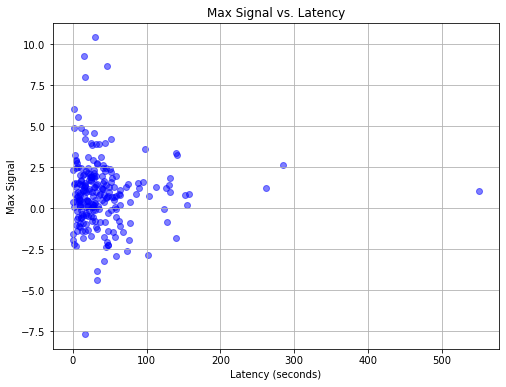

In [92]:

from scipy.stats import pearsonr


max_signals = VMH_snips["max_signal"]
latencies = VMH_snips["latency"]
# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(latencies, max_signals)
# Print the correlation results
print(f"Pearson correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")
# Interpret the significance
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(latencies, max_signals, c='blue', alpha=0.5)
plt.title('Max Signal vs. Latency')
plt.xlabel('Latency (seconds)')
plt.ylabel('Max Signal')
plt.grid(True)
plt.show()

In [119]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
def get_snips_2(data, mice):
    results = {}
    kwargs = {"bins": 150, "trial_length": 15, "baseline_length": 5}
    pre = 5
    post = 10
    mineventlength = 8
    binlength = 0.1
    for mouse in mice:
        for session, val in data.items():
            if val["mouse_ID"] == mouse:
                if len(val["licks"]) < 10:
                    continue
                lickdata = tp.lickCalc(val["licks"], minrunlength=3)
                snipper = tp.Snipper(val["corrected"],
                                     lickdata["rStart"],
                                     end=lickdata["rEnd"],
                                     fs=val["fs"],
                                     pre=pre,
                                     post=post,
                                     binlength=binlength,
                                     zscore=True
                                     )
                snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6, 2])
                snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
                
                session_snips = []
                session_aucs = []
                snip_sequence = []
                # Collect snips, calculate combined AUC, and track sequence
                for i, snip in enumerate(snipper.snips, start=1):
                    auc_50_110 = simps(snip[50:110], dx=binlength)
                    auc_120_140 = simps(snip[120:140], dx=binlength)
                    combined_auc = auc_50_110 + auc_120_140
                    session_snips.append(snip)
                    session_aucs.append(combined_auc)
                    snip_sequence.append(i)
                # Store results for the session
                results[session] = {
                    "snips": np.array(session_snips),
                    "combined_aucs": np.array(session_aucs),
                    "sequence": np.array(snip_sequence)
                }
    return results

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 2 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.


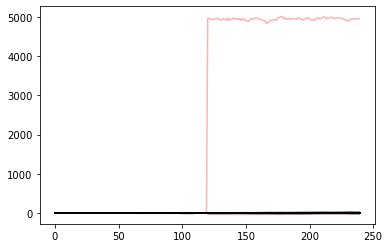

In [120]:
PVH_snips_2= get_snips_2(PVH, PVH_list_of_mice)
VMH_snips_2= get_snips_2(VMH, VMH_list_of_mice)

Pearson correlation coefficient: -0.017
P-value: 0.786
The correlation is not statistically significant.


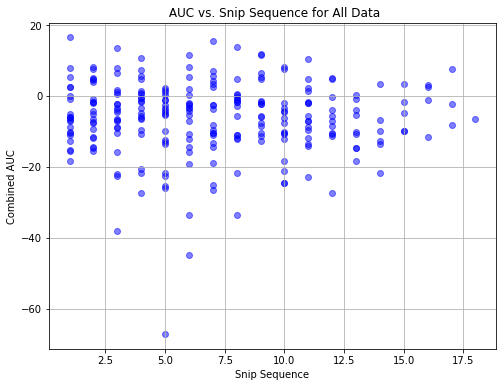

In [124]:
all_aucs = []
all_sequences = []
# Aggregate data across all sessions
for session, data in PVH_snips_2.items():
    all_aucs.extend(data["combined_aucs"])
    all_sequences.extend(data["sequence"])
# Convert to numpy arrays
all_aucs = np.array(all_aucs)
all_sequences = np.array(all_sequences)
# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(all_sequences, all_aucs)
# Print the correlation results
print(f"Pearson correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")
# Interpret the significance
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")
# Create a scatter plot for all data
plt.figure(figsize=(8, 6))
plt.scatter(all_sequences, all_aucs, c='blue', alpha=0.5)
plt.title(' AUC vs. Snip Sequence for All Data')
plt.xlabel('Snip Sequence')
plt.ylabel('Combined AUC')
plt.grid(True)
plt.show()

Pearson correlation coefficient: -0.111
P-value: 0.086
The correlation is not statistically significant.


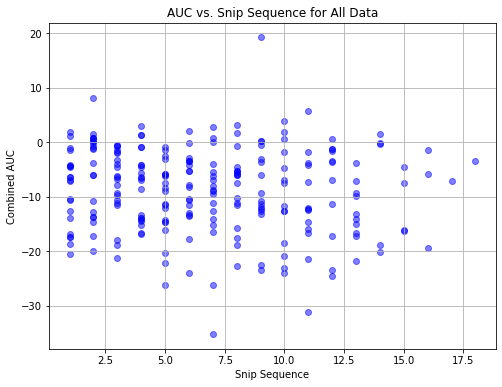

In [125]:
all_aucs = []
all_sequences = []
# Aggregate data across all sessions
for session, data in VMH_snips_2.items():
    all_aucs.extend(data["combined_aucs"])
    all_sequences.extend(data["sequence"])
# Convert to numpy arrays
all_aucs = np.array(all_aucs)
all_sequences = np.array(all_sequences)
# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(all_sequences, all_aucs)
# Print the correlation results
print(f"Pearson correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")
# Interpret the significance
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")
# Create a scatter plot for all data
plt.figure(figsize=(8, 6))
plt.scatter(all_sequences, all_aucs, c='blue', alpha=0.5)
plt.title('AUC vs. Snip Sequence for All Data')
plt.xlabel('Snip Sequence')
plt.ylabel('Combined AUC')
plt.grid(True)
plt.show()